# 2D Acoustic Wave Equation
---

Consider the 2d acoustic wave equation
$$
\begin{aligned}
&\frac{\partial p}{\partial t} = -c^2(x, z)\rho(x, z)\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial z}\right) + f(x, z, t) \\
&\frac{\partial u}{\partial t} = -\frac{1}{\rho(x, z)}\frac{\partial p}{\partial x} \\
&\frac{\partial v}{\partial t} = -\frac{1}{\rho(x, z)}\frac{\partial p}{\partial z},
\end{aligned}
$$
where $p$ is Pressure, $u, v$ are the $x, z-$components of Particle Velocity, $c, \rho$ are Medium Velocity and Density.

The RHS
$$
f(x, z, t) = R(t)\times 1_{\{x = x_s, z = z_s, t\}} 
$$
is the source term, represented by a Ricker wavelet
$$
R(t) = \left(1-2(\pi f_0(t-t_0))^2\right)\exp\left(-(\pi f_0(t-t_0))^2\right),
$$
where $f_0 = 50$ is the dominant frequency, $t_0 = 0.05$ is time delay.

<p style="color:red"> We can probably use the same technique as the numerical code, i.e., $f(x, z, t) = R(t)\times N(x, z)$, where $N(x, z)$ is a Gaussian centering at $(x_s, z = z_s)$ ? </p>

In this case,
$$
N(x, z) = \exp\left(-\frac{1}{\alpha^2}\left((x-x_s)^2+(z-z_s)^2\right)\right).
$$

---

## Scaling

Since the spatial and temporal domains differs in a large scale, we need to scale both domains to $[0, 1]$ before providing data directly into neural networks.

Let 
$$
x' = \frac{x}{x_0}, \ z' = \frac{z}{z_0}, \ t' = \frac{t}{t_0}, \ p' = \frac{p}{p_0}, \ u' = \frac{u}{u_0}, \ v' = \frac{v}{v_0}, \ c' = \frac{c}{c_0},
$$
where $x_0, z_0, t_0, p_0, u_0, v_0, c_0$ are scaling factors TBD.

Then the equations become
$$
\begin{aligned}
&\frac{p_0}{t_0}\frac{\partial p'}{\partial t'} = -c_0^2 c'^2(x_0x', z_0z')\rho(x_0x', z_0z')\left(\frac{u_0}{x_0}\frac{\partial u'}{\partial x'} + \frac{v_0}{z_0}\frac{\partial v'}{\partial z'}\right) + R(t_0 t')N(x_0x', z_0z', x_{0}x_s', z_{0}z_s') \\
&\frac{u_0}{t_0}\frac{\partial u'}{\partial t'} = -\frac{1}{\rho(x_0x', z_0z')}\frac{p_0}{x_0}\frac{\partial p'}{\partial x'} \\
&\frac{v_0}{t_0}\frac{\partial v'}{\partial t'} = -\frac{1}{\rho(x_0x', z_0z')}\frac{p_0}{z_0}\frac{\partial p'}{\partial z'}, 
\end{aligned}
$$

direct model: $(x', z', t', x_s') \to (p', u', v')$

inverse model: $(x', z') \to c$

Since $x, z \sim O(10^{2}),\ t\sim O(10^{-1}),\ p \sim O(10^{-3}),\ v \sim O(10^{-10})$, we can let
$$
x_0 = z_0 = 10^3, \ t_0 = 1, \ p_0 = u_0 = v_0 = 1, \ c_0 = 10^3,
$$

then the unit of $x, z$ are $km$, and the unit of $c$ is $km/s$.


---

## Data

- $u$ is unknown
- $v_z$: Velocity in $z-$ direction; the $v$ variable in the equation
- $p$: Pressure
- $\rho(x, z)$: Medium density; We first assume it to be known as
$$
\rho(x, z) = \left\{
\begin{aligned}
&2000, &\quad z\in [100, 150], \\
&1000, &\quad \text{otherwise}.
\end{aligned}
\right.
$$

- All known data are collected in the spatial domain $(x, z) \in [1, 250]\times [1, 250]$, with grid size 5 (which means the spatial grids are {5, 10, ..., 250}. The temporal domain is $t\in [0, 0.25)$, with time step $dt = 0.0025$. This gives 100 time steps as recorded.

- The sources are located at $(x_s, z_s) = \{25, 50, \cdots, 225\} \times \{5\}$.

## Target
- Recover the direct problem $p, u, v$
- Recover the inverse problem $c$

In [9]:
NAME = "0627_1_direct_model_with_source_input_scale_equation"

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("../../")
from Seismic_wave_inversion_PINN.tf_model_utils import *
from Seismic_wave_inversion_PINN.data_utils import *

plt.rcParams.update(plt.rcParamsDefault)
tf.keras.backend.set_floatx("float32")

%load_ext autoreload
%autoreload 2

In [3]:
def generate_model(layers, softplus = False):
	with tf.device("/device:gpu:0"):
		a = tf.Variable(np.ones((len(layers)-2, 1)), dtype = tf.float32)

		def atanh(a, x):
			return K.tanh(a*x)

		model = keras.models.Sequential()
		for i, l in enumerate(layers[:-2]):
			model.add(keras.layers.Dense(layers[i+1], input_shape = (layers[i], ), activation = lambda x: atanh(a[i], x)))
		if softplus:
			model.add(keras.layers.Dense(layers[-1], activation = "softplus"))
		else:
			model.add(keras.layers.Dense(layers[-1]))

		model.a = a
	return model

N_models = 1
direct_layers = [4, 32, 32, 32, 32, 3] # (x, z, t, xs) -> (p, u, v)
direct_models = [generate_model(direct_layers) for i in range(N_models)]

inverse_layers = [2, 32, 32, 1] # (x, z) -> (c)
inverse_model = generate_model(inverse_layers, softplus = True)

In [4]:
x0, z0, t0 = 1e3, 1e3, 1.0
p0, u0, v0 = 1.0, 1.0, 1.0
c0 = 1e3

In [5]:
@tf.function
def rho(x, z):
	return tf.where(tf.math.logical_and(tf.greater_equal(z, 100.0), tf.less_equal(z, 150.0)),
				   2000.0,
				   1000.0)

# source
f_0 = 50.0*np.pi
alpha = 2.0*5 # multiplied by dx
M0 = 1000 # scale p

@tf.function
def R(t, t_s):
	return M0*(1-2*(f_0*(t-t_s))**2)*tf.exp(-(f_0*(t-t_s))**2)

@tf.function
def N(x, z, x_s, z_s):
	return tf.exp(-1.0/(alpha**2) * ((x-x_s)**2 + (z-z_s)**2))

@tf.function
def f(x, z, t, x_s, z_s, t_s):
	return R(t, t_s)*N(x, z, x_s, z_s)

In [6]:
loss_func = keras.losses.MeanSquaredError()
loss_func_r = keras.losses.MeanAbsoluteError()

def get_residue_loss(tape, p, u, v, c, x, z, t, x_s, z_s, t_s):
	dp_dt = tape.gradient(p, t)
	dp_dx = tape.gradient(p, x)
	dp_dz = tape.gradient(p, z)
	du_dt = tape.gradient(u, t)
	du_dx = tape.gradient(u, x)
	dv_dt = tape.gradient(v, t)
	dv_dz = tape.gradient(v, z)
	eq1 = loss_func_r(p0/t0*dp_dt, -c0**2*tf.square(c)*rho(x0*x, z0*z)*(u0/x0*du_dx+v0/z0*dv_dz)+f(x0*x, z0*z, t0*t, x0*x_s, z0*z_s, t0*t_s))
	eq2 = loss_func_r(u0/t0*du_dt, -1.0/rho(x0*x, z0*z)*p0/x0*dp_dx)
	eq3 = loss_func_r(v0/t0*dv_dt, -1.0/rho(x0*x, z0*z)*p0/z0*dp_dz)
	return eq1+eq2+eq3
	
# data: [x_c, z_c, t_c, 
#                x_d, z_d, t_d, p_d, v_d
#                x_i, z_i, t_i, p_i, u_i, v_i
#                x_s, z_s, t_s]
def step(data_sources):
	losses = []
	with tf.GradientTape(persistent = True) as tape:
		tape.watch([x for d in data_sources for x in d])
		for (data, direct_model) in zip(data_sources, direct_models):
			[x_c, z_c, t_c, x_d, z_d, t_d, p_d, v_d, x_i, z_i, t_i, p_i, u_i, v_i, x_s_c, x_s_d, x_s_i, z_s, t_s] = data
			out_c = direct_model(tf.concat([x_c, z_c, t_c, x_s_c], axis = 1))
			c_c = inverse_model(tf.concat([x_c, z_c], axis = 1))
			out_d = direct_model(tf.concat([x_d, z_d, t_d, x_s_d], axis = 1))
			c_d = inverse_model(tf.concat([x_d, z_d], axis = 1))
			out_i = direct_model(tf.concat([x_i, z_i, t_i, x_s_i], axis = 1))
			c_i = inverse_model(tf.concat([x_i, z_i], axis = 1))
			loss_c = get_residue_loss(tape, out_c[:, 0:1], out_c[:, 1:2], out_c[:, 2:3], c_c, x_c, z_c, t_c, x_s_c, z_s, t_s)
			loss_dr = get_residue_loss(tape, out_d[:, 0:1], out_d[:, 1:2], out_d[:, 2:3], c_d, x_d, z_d, t_d, x_s_d, z_s, t_s)
			loss_dv = loss_func(out_d[:, 0:1], p_d) # + loss_func(out_d[:, 2:3], v_d)
			loss_ir = get_residue_loss(tape, out_i[:, 0:1], out_i[:, 1:2], out_i[:, 2:3], c_i, x_i, z_i, t_i, x_s_i, z_s, t_s)
			loss_iv = loss_func(out_i[:, 0:1], p_i) + loss_func(out_i[:, 1:2], u_i) + loss_func(out_i[:, 2:3], v_i)
			losses.append([loss_c, loss_dr, loss_dv, loss_ir, loss_iv])

		loss_c = sum([l[0] for l in losses])
		loss_dr = sum([l[1] for l in losses])
		loss_dv = sum([l[2] for l in losses])
		loss_ir = sum([l[3] for l in losses])
		loss_iv = sum([l[4] for l in losses])
		
		loss = w_c*loss_c + w_dr*loss_dr + w_dv*loss_dv + w_ir*loss_ir + w_iv*loss_iv
		
	grads = tape.gradient(loss, [v for model in direct_models for v in model.trainable_variables] + \
						  inverse_model.trainable_variables + [model.a for model in direct_models])
	optimizer.apply_gradients(zip(grads, [v for model in direct_models for v in model.trainable_variables] + \
								  inverse_model.trainable_variables + [model.a for model in direct_models]))
	del tape
	return loss, loss_c, loss_dr, loss_dv, loss_ir, loss_iv

# d_s, d_i, d_c, d_d: dataset for each source


# data_sources: [d_1, ..., d_s]; dataset for each source
# d_j: [d_j_i, d_j_c, d_j_d, d_j_s]
# d_j_i: [x_i, z_i, t_i, p_i, u_i, v_i]
# d_j_c: [x_c, z_c, t_c]
# d_j_d: [x_d, z_d, t_d, p_d, v_d]
# d_j_s: [x_s, z_s, t_s]
def train(data_sources, epochs, batch_proportion = 0.1, print_every = 100, save_every = 10000, save_path = None):
	shuffled = lambda dataset: [tf.data.Dataset.from_tensor_slices(tuple(d)).shuffle(buffer_size = max(d[0].shape[0], 1), \
                                                        reshuffle_each_iteration = True).batch(max(int(batch_proportion*d[0].shape[0]), 1)) \
                                        for d in dataset]
	data_s = shuffled([d for d_s in data_sources for d in d_s[:-1]])
	source_locations = [d[-1] for d in data_sources]
	for epoch in range(1, epochs+1):
		losses = np.zeros((6,))
		for d in zip(*data_s): # d: [d_1_i, d_1_c, d_1_d, d_2_i, ...]
			data_sources = [list(d[i*3+1])+list(d[i*3+2])+list(d[i*3])+source_locations[i] for i in range(n_sources)]
			loss = step(data_sources)
			losses += np.array(loss)
		losses *= batch_proportion
		
		if epoch % print_every == 0:
			print("{}, Epoch: {}, Loss: {:.4e}, loss_c: {:.4e}, \
					  loss_dr: {:.4e}, loss_dv: {:.4e}, loss_ir: {:.4e}, loss_iv: {:.4e}".format(get_time(), epoch, *list(losses)))

		if epoch % save_every == 0:
			for i, model in enumerate(direct_models):
				model.save("models/{}/{}/direct_model_{}/".format(NAME, save_path, i))
			inverse_model.save("models/{}/{}/inverse_model".format(NAME, save_path))

In [7]:
from scipy.io import loadmat

x_s = np.linspace(25.0, 225.0, 9) / x0
z_s = 5.0 / z0
t_s = 0.05 / t0
n_sources = len(x_s)

domain = [0, 250]
T_max = 0.25
dx = 5
dt = 0.0025

x_d = np.linspace(5.0, 250.0, 50) / x0
z_d = np.array([5.0]) / z0
t_d = np.linspace(0.0, 0.2475, 100) / t0

n_c = 1000
x_c = transform(np.random.random((n_c, 1)), *domain) / x0
z_c = transform(np.random.random((n_c, 1)), *domain) / z0
t_c = transform(np.random.random((n_c, 1)), 0, T_max) / t0

n_s = 100
x_c_source = np.vstack([transform(np.random.random((n_s, 1)), xi-5, xi+5) for xi in x_s]) / x0
z_c_source = np.vstack([transform(np.random.random((n_s, 1)), z_s-5, z_s+5) for i in x_s]) / z0
t_c_source = np.vstack([transform(np.random.random((n_s, 1)), t_s-0.05, t_s+0.05) for i in x_s]) / t0

x_c = np.vstack([x_c, x_c_source]) / x0
z_c = np.vstack([z_c, z_c_source]) / z0
t_c = np.vstack([t_c, t_c_source]) / t0

n_i = 2000
x_i = transform(np.random.random((n_i, 1)), *domain) / x0
z_i = transform(np.random.random((n_i, 1)), *domain) / z0
t_i = np.zeros_like(x_i) / t0
p_i = np.zeros_like(x_i) / p0
u_i = np.zeros_like(x_i) / u0
v_i = np.zeros_like(x_i) / v0

# txz_c = tensor_grid([t_c, x_c, z_c])
txz_d = tensor_grid([t_d, x_d, z_d])

map_to_tf_float32 = lambda x: list(map(lambda y: tf.constant(y, dtype = tf.float32), x))

data_sources = []
for x in x_s:
	p = loadmat("data/sr_p_{}.mat".format(int(x*x0/5)))["sr"].reshape((-1, 1)) / p0
	v = loadmat("data/sr_vz_{}.mat".format(int(x*x0/5)))["sr"].reshape((-1, 1)) / v0
	d_i = map_to_tf_float32([x_i, z_i, t_i, p_i, u_i, v_i])
# 	d_c = map_to_tf_float32([txz_c[:, 1:2], txz_c[:, 2:3], txz_c[:, 0:1]])
	d_c = map_to_tf_float32([x_c, z_c, t_c])
	d_d = map_to_tf_float32([txz_d[:, 1:2], txz_d[:, 2:3], txz_d[:, 0:1], p, v])
	d_s = map_to_tf_float32([x*np.ones_like(x_c), x*np.ones_like(txz_d[:, 1:2]), x*np.ones_like(x_i), z_s, t_s])
	data_sources.append([d_i, d_c, d_d, d_s])

In [8]:
i = 1
optimizer = keras.optimizers.Adam(lr = 1e-4)
w_c, w_dr, w_dv, w_ir, w_iv = 1.0, 1.0, 1e8, 1.0, 1e8
train(data_sources, 10000, batch_proportion = 1.0, print_every = 100, save_every = 10000, save_path = "{}_adam".format(i))

2020/06/27, 16:18:38, Epoch: 100, Loss: 3.7620e+03, loss_c: 5.2719e+02, 					  loss_dr: 3.7498e+02, loss_dv: 2.8474e-06, loss_ir: 3.5414e+02, loss_iv: 2.2210e-05
2020/06/27, 16:19:36, Epoch: 200, Loss: 1.6262e+03, loss_c: 1.6926e+02, 					  loss_dr: 5.8188e+02, loss_dv: 1.9858e-08, loss_ir: 5.2650e+02, loss_iv: 3.4659e-06
2020/06/27, 16:20:34, Epoch: 300, Loss: 9.4497e+02, loss_c: 2.7521e+02, 					  loss_dr: 2.9786e+02, loss_dv: 7.5540e-09, loss_ir: 2.9745e+02, loss_iv: 7.3691e-07
2020/06/27, 16:21:32, Epoch: 400, Loss: 1.1175e+03, loss_c: 2.1286e+02, 					  loss_dr: 4.8135e+02, loss_dv: 6.8552e-09, loss_ir: 4.0784e+02, loss_iv: 1.4789e-07
2020/06/27, 16:22:30, Epoch: 500, Loss: 7.4343e+02, loss_c: 2.1568e+02, 					  loss_dr: 2.3232e+02, loss_dv: 6.6446e-09, loss_ir: 2.9270e+02, loss_iv: 2.0666e-08
2020/06/27, 16:23:28, Epoch: 600, Loss: 7.4828e+02, loss_c: 2.2891e+02, 					  loss_dr: 2.1587e+02, loss_dv: 6.5163e-09, loss_ir: 3.0181e+02, loss_iv: 1.0452e-08
2020/06/27, 16:24:26, Epoch:

2020/06/27, 16:51:27, Epoch: 3500, Loss: 6.4630e+01, loss_c: 1.5080e+01, 					  loss_dr: 2.7937e+01, loss_dv: 5.6289e-09, loss_ir: 2.0718e+01, loss_iv: 3.3174e-09
2020/06/27, 16:52:26, Epoch: 3600, Loss: 7.4304e+01, loss_c: 2.7338e+01, 					  loss_dr: 2.3010e+01, loss_dv: 5.6353e-09, loss_ir: 2.3011e+01, loss_iv: 3.8210e-09
2020/06/27, 16:53:24, Epoch: 3700, Loss: 5.6420e+01, loss_c: 1.3522e+01, 					  loss_dr: 2.5181e+01, loss_dv: 5.6205e-09, loss_ir: 1.6830e+01, loss_iv: 3.2486e-09
2020/06/27, 16:54:22, Epoch: 3800, Loss: 4.9585e+01, loss_c: 1.1025e+01, 					  loss_dr: 2.2027e+01, loss_dv: 5.6332e-09, loss_ir: 1.5654e+01, loss_iv: 3.1590e-09
2020/06/27, 16:55:20, Epoch: 3900, Loss: 5.6756e+01, loss_c: 2.0577e+01, 					  loss_dr: 1.8196e+01, loss_dv: 5.6058e-09, loss_ir: 1.7047e+01, loss_iv: 3.7480e-09
2020/06/27, 16:56:18, Epoch: 4000, Loss: 4.4364e+01, loss_c: 1.0980e+01, 					  loss_dr: 1.9923e+01, loss_dv: 5.5631e-09, loss_ir: 1.2595e+01, loss_iv: 3.1064e-09
2020/06/27, 16:57:16, 

2020/06/27, 17:40:50, Epoch: 8600, Loss: 6.0497e+00, loss_c: 6.7003e-01, 					  loss_dr: 3.7847e+00, loss_dv: 6.6951e-09, loss_ir: 6.0360e-01, loss_iv: 3.2182e-09
2020/06/27, 17:41:48, Epoch: 8700, Loss: 5.6788e+00, loss_c: 6.5213e-01, 					  loss_dr: 3.7613e+00, loss_dv: 5.0343e-09, loss_ir: 5.8438e-01, loss_iv: 1.7754e-09
2020/06/27, 17:42:46, Epoch: 8800, Loss: 5.6191e+00, loss_c: 6.3523e-01, 					  loss_dr: 3.7398e+00, loss_dv: 5.0285e-09, loss_ir: 5.6587e-01, loss_iv: 1.7536e-09
2020/06/27, 17:43:44, Epoch: 8900, Loss: 5.5467e+00, loss_c: 6.1034e-01, 					  loss_dr: 3.7184e+00, loss_dv: 5.0286e-09, loss_ir: 5.4461e-01, loss_iv: 1.7051e-09
2020/06/27, 17:44:42, Epoch: 9000, Loss: 5.4852e+00, loss_c: 5.9610e-01, 					  loss_dr: 3.6989e+00, loss_dv: 4.9889e-09, loss_ir: 5.2849e-01, loss_iv: 1.6285e-09
2020/06/27, 17:45:40, Epoch: 9100, Loss: 6.6638e+00, loss_c: 5.7412e-01, 					  loss_dr: 3.6831e+00, loss_dv: 1.1588e-08, loss_ir: 5.0701e-01, loss_iv: 7.4076e-09
2020/06/27, 17:46:38, 

NameError: name 'NAME' is not defined

In [13]:
i = 2
optimizer = keras.optimizers.Adam(lr = 1e-4)
w_c, w_dr, w_dv, w_ir, w_iv = 1.0, 1e4, 1e8, 1e4, 1e8
train(data_sources, 100000, batch_proportion = 1.0, print_every = 100, save_every = 10000, save_path = "{}_adam".format(i))

2020/06/27, 18:12:18, Epoch: 100, Loss: 3.0990e+04, loss_c: 1.0872e-01, 					  loss_dr: 3.0978e+00, loss_dv: 2.9662e-08, loss_ir: 7.3015e-04, loss_iv: 1.2249e-08
2020/06/27, 18:13:15, Epoch: 200, Loss: 3.0990e+04, loss_c: 1.0906e-01, 					  loss_dr: 3.0980e+00, loss_dv: 1.7565e-08, loss_ir: 6.6701e-04, loss_iv: 1.9138e-08
2020/06/27, 18:14:11, Epoch: 300, Loss: 3.0984e+04, loss_c: 1.0872e-01, 					  loss_dr: 3.0975e+00, loss_dv: 1.3746e-08, loss_ir: 5.7745e-04, loss_iv: 1.4396e-08
2020/06/27, 18:15:08, Epoch: 400, Loss: 3.0985e+04, loss_c: 1.0895e-01, 					  loss_dr: 3.0978e+00, loss_dv: 6.6109e-09, loss_ir: 5.5323e-04, loss_iv: 1.5692e-09
2020/06/27, 18:16:05, Epoch: 500, Loss: 3.0980e+04, loss_c: 1.0841e-01, 					  loss_dr: 3.0974e+00, loss_dv: 5.2706e-09, loss_ir: 5.1125e-04, loss_iv: 6.6423e-10
2020/06/27, 18:17:02, Epoch: 600, Loss: 3.0989e+04, loss_c: 1.0902e-01, 					  loss_dr: 3.0980e+00, loss_dv: 5.7651e-09, loss_ir: 7.9315e-04, loss_iv: 6.0080e-10
2020/06/27, 18:17:59, Epoch:

KeyboardInterrupt: 

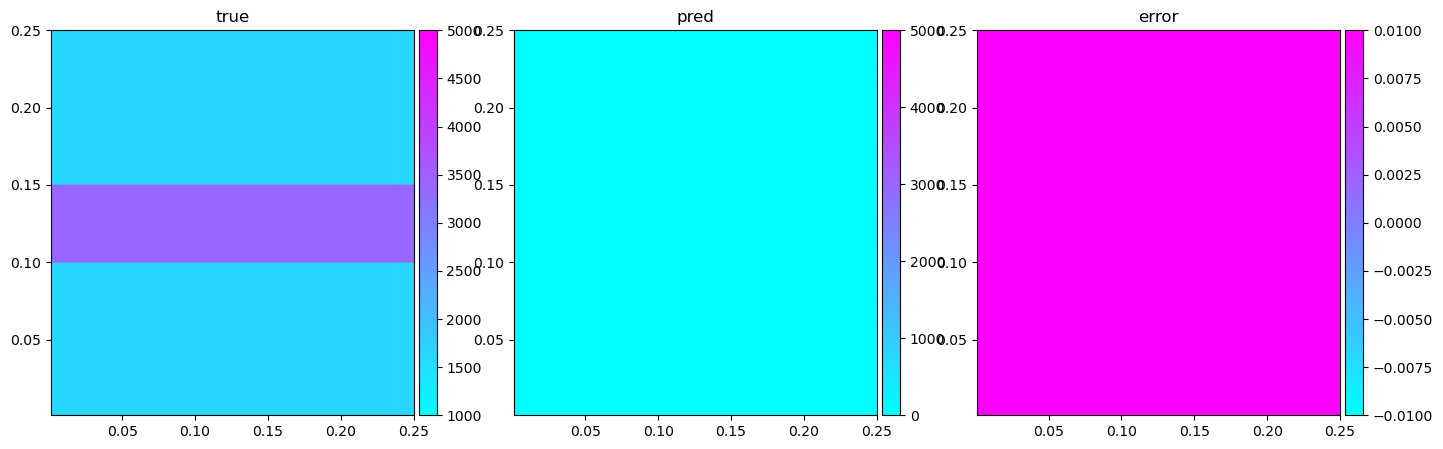

In [19]:
x_test = np.linspace(1.0, 250.0, 250) / x0
z_test = np.linspace(1.0, 250.0, 499) / z0
xz_test = tensor_grid([x_test, z_test])

c_pred = inverse_model(tf.constant(xz_test, dtype = tf.float32))*c0
def c_func(x, z):
	return np.piecewise(z, [z > 150, (z >= 100) & (z <= 150), z < 100], [1500, 3500, 1500])
c_true = c_func(xz_test[:, 0:1]*x0, xz_test[:, 1:2]*z0)

import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = cool
norm = Normalize(vmin=1000, vmax=5000)

X, Z = np.meshgrid(x_test, z_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, Z, c_true.reshape((len(x_test), len(z_test))).T, cmap = cmap, norm = norm)
ax[0].set_title("true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=0, vmax=5000)
im1 = ax[1].contourf(X, Z, c_pred.numpy().reshape((len(x_test), len(z_test))).T, cmap = cmap, norm = norm)
ax[1].set_title("pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
im2 = ax[2].contourf(X, Z, c_true.reshape((len(x_test), len(z_test))).T-c_pred.numpy().reshape((len(x_test), len(z_test))).T, cmap = cmap, norm = norm)
ax[2].set_title("error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()

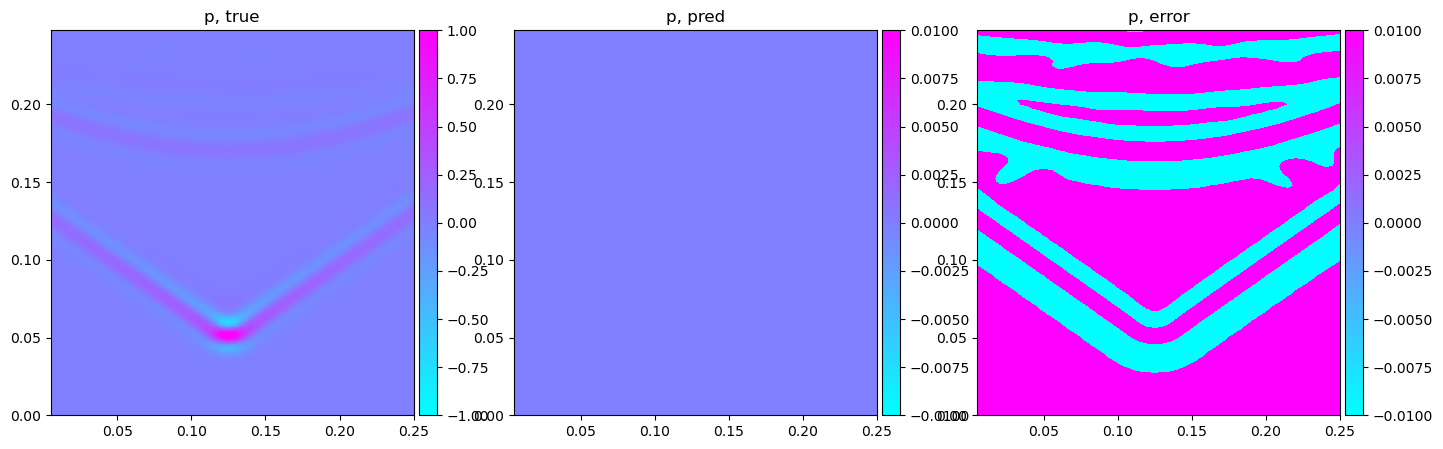

In [23]:
i = 0
p = loadmat("data/sr_p_{}.mat".format(int(x_s[i]*x0)))["sr"]*1000
v = loadmat("data/sr_vz_{}.mat".format(int(x_s[i]*x0)))["sr"]

x_test = np.linspace(5.0, 250.0, 50) / x0
# z_test = np.linspace(1.0, 250.0, 250)
z_test = np.array([0]) / z0
t_test = np.linspace(0.0, 0.2475, 100) / t0
xzt_test = tensor_grid([t_test, x_test, z_test])
xzt_test[:, [0, 1, 2]] = xzt_test[:, [1, 2, 0]]

xzts = np.hstack([xzt_test, x_s[i]*np.ones_like(xzt_test[:, 0:1])])
out = direct_models[i](tf.constant(xzts, dtype = tf.float32))

cmap = cool
norm = Normalize(vmin=-1, vmax=1)

X, T = np.meshgrid(x_test, t_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, T, p, cmap = cmap, norm = norm, levels = 1000)
ax[0].set_title("p, true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = Normalize(vmin=-0.01, vmax=0.01)
im1 = ax[1].contourf(X, T, out[:, 0:1].numpy().reshape((len(x_test), len(t_test))).T, cmap = cmap, norm = norm, levels = 1000)
ax[1].set_title("p, pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
im2 = ax[2].contourf(X, T, p-out[:, 0:1].numpy().reshape((len(x_test), len(t_test))).T, cmap = cmap, norm = norm)
ax[2].set_title("p, error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()

In [24]:
out

<tf.Tensor: shape=(5000, 3), dtype=float32, numpy=
array([[-3.0105934e-05, -3.1986739e-05,  3.3657649e-05],
       [-2.9969029e-05, -3.1272299e-05,  3.2294774e-05],
       [-2.9845978e-05, -3.0555646e-05,  3.0931202e-05],
       ...,
       [-1.2959354e-05, -1.0348216e-04,  5.3462107e-05],
       [-1.1120341e-05, -1.0406261e-04,  5.2305637e-05],
       [-9.2494301e-06, -1.0467239e-04,  5.1158597e-05]], dtype=float32)>